In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yfin
import StockPull
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
yfin.pdr_override()

#load data
company = 'tsla'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)

data = StockPull.analysisout(company)

#prepare data

# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1,1))
train_dates = pd.to_datetime(data['Date'])
cols = list(data)[1:3]
df_for_training = data[cols].astype(float)

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

prediction_days = 60
n_future = 1
n_past = 60

x_train = []
y_train = []
trainX = []
trainY = []

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)


# for x in range(prediction_days, len(scaled_data)):
#     x_train.append(scaled_data[x-prediction_days:x, 0])
#     y_train.append(scaled_data[x,0])
#
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [21]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print(df_for_training_scaled)

trainX shape == (1199, 60, 2).
trainY shape == (1199, 1).
[[-9.11025798e-01 -6.99467967e-01]
 [-9.10609946e-01 -6.34029549e-01]
 [-9.16235160e-01  7.19783901e-04]
 ...
 [ 3.43177233e-01 -5.87369208e-01]
 [ 4.55203741e-01 -2.42837709e-01]
 [ 4.52337780e-01 -8.95271154e-01]]


In [3]:

#build the model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1)) #prediction of the next closing value)

model.compile(optimizer ='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25
38/38 [==============================] - 4s 27ms/step - loss: 0.0193
Epoch 2/25
38/38 [==============================] - 1s 33ms/step - loss: 0.0032
Epoch 3/25
38/38 [==============================] - 1s 28ms/step - loss: 0.0030
Epoch 4/25
38/38 [==============================] - 1s 27ms/step - loss: 0.0029
Epoch 5/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0024
Epoch 6/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0022
Epoch 7/25
38/38 [==============================] - 1s 29ms/step - loss: 0.0023
Epoch 8/25
38/38 [==============================] - 1s 30ms/step - loss: 0.0020
Epoch 9/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0021
Epoch 10/25
38/38 [==============================] - 1s 32ms/step - loss: 0.0019
Epoch 11/25
38/38 [==============================] - 1s 31ms/step - loss: 0.0020
Epoch 12/25
38/38 [==============================] - 1s 28ms/step - loss: 0.0024
Epoch 13/25
38/38 [==================

In [4]:
#TEST THE MODEL ACCURACY

test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()

test_data = StockPull.analysisout(company, '5y','1d')
actual_prices = test_data ['Price'].values

total_dataset = pd.concat((data['Price'], test_data['Price']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inpts = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inpts)


In [5]:
#makeprediction on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


40/40 [==============================] - 1s 9ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


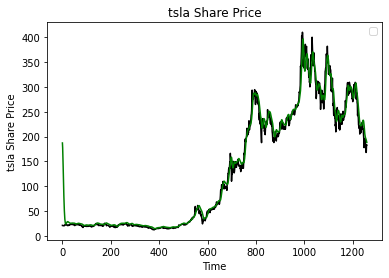

In [6]:
#plot the test predictions
plt.plot(actual_prices, color = "black")
plt.plot(predicted_prices, color = "green")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


In [7]:
#Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction =  model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 673ms/step
Prediction: [[187.00543]]
